In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from copy import deepcopy

from vae import VAE, train_vae, reparameterize 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data preparation

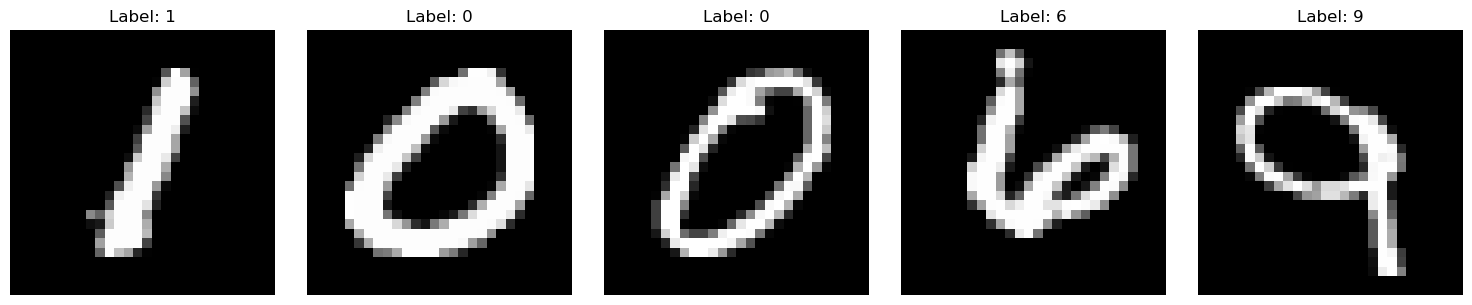

In [3]:
# Get current working directory
DATA_DIR = os.path.join(os.getcwd(), 'datasets', 'mnist')

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0, 1] range
])

dataset = datasets.MNIST(root=DATA_DIR, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=DATA_DIR, train=False, transform=transform)

# Split training into training and validation
train_dataset, val_dataset = random_split(dataset, [50000, 10000])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128);

# Visaulize some samples from training set
plt.figure(figsize=(15, 3))

# Print the first few images in a row
for i, (image, label) in enumerate(train_loader):
    if i < 5:  # Print the first 5 samples
        plt.subplot(1, 5, i + 1)
        plt.imshow(image[0].squeeze(), cmap='gray')
        plt.title(f"Label: {label[0].item()}")
        plt.axis('off')
    else:
        break  # Exit the loop after printing 5 samples

plt.tight_layout()
plt.show()

### 1a. Model setup

In [4]:
latent_dim = 20
model = VAE(latent_dim=latent_dim).to(device)

### 1b. Model training

In [ ]:
epochs = 30
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model, train_losses, val_losses = train_vae(
    model,
    train_loader,
    val_loader,
    optimizer = optimizer,
    device = device,
    epochs=epochs,
    patience=None   # No early stopping
    )


Epoch 1, Train -Loss (ELBO): -29.19, Val -Loss (ELBO): -29.17
Epoch 2, Train -Loss (ELBO): -29.11, Val -Loss (ELBO): -29.11
Epoch 3, Train -Loss (ELBO): -29.08, Val -Loss (ELBO): -29.18
Epoch 4, Train -Loss (ELBO): -29.07, Val -Loss (ELBO): -29.09
Epoch 5, Train -Loss (ELBO): -29.07, Val -Loss (ELBO): -29.05
Epoch 6, Train -Loss (ELBO): -29.04, Val -Loss (ELBO): -29.05
Epoch 7, Train -Loss (ELBO): -29.05, Val -Loss (ELBO): -29.06
Epoch 8, Train -Loss (ELBO): -29.04, Val -Loss (ELBO): -29.13
Epoch 9, Train -Loss (ELBO): -29.05, Val -Loss (ELBO): -29.10
Epoch 10, Train -Loss (ELBO): -29.04, Val -Loss (ELBO): -29.03
Epoch 11, Train -Loss (ELBO): -29.04, Val -Loss (ELBO): -29.01


#### Plot training and validation loss

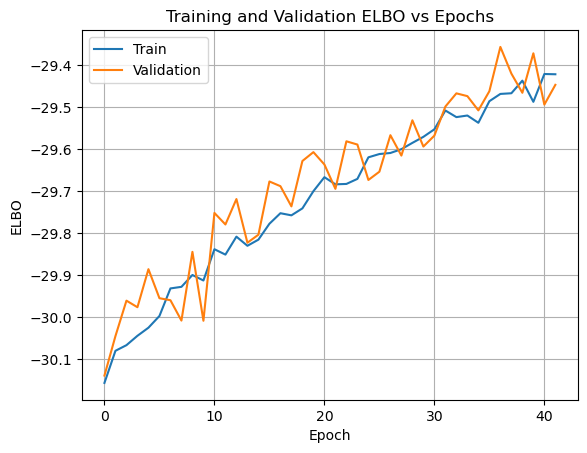

In [ ]:
plt.plot([-loss for loss in train_losses], label='Train')
plt.plot([-loss for loss in val_losses], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('ELBO')
plt.title('Training and Validation ELBO vs Epochs')
plt.legend()
plt.grid()
plt.show()

### 1c. Stopping criteria

In [6]:
patience = 5  # Early stopping criteria
epochs = 100
model, train_losses, val_losses = train_vae(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    epochs=epochs,
    patience=5  # Enable early stopping
)
torch.save(model.state_dict(), "best_model.pt")

Epoch 1, Train -Loss (ELBO): -30.16, Val -Loss (ELBO): -30.14
Epoch 2, Train -Loss (ELBO): -30.08, Val -Loss (ELBO): -30.05
Epoch 3, Train -Loss (ELBO): -30.07, Val -Loss (ELBO): -29.96
Epoch 4, Train -Loss (ELBO): -30.04, Val -Loss (ELBO): -29.98
Epoch 5, Train -Loss (ELBO): -30.03, Val -Loss (ELBO): -29.89
Epoch 6, Train -Loss (ELBO): -30.00, Val -Loss (ELBO): -29.95
Epoch 7, Train -Loss (ELBO): -29.93, Val -Loss (ELBO): -29.96
Epoch 8, Train -Loss (ELBO): -29.93, Val -Loss (ELBO): -30.01
Epoch 9, Train -Loss (ELBO): -29.90, Val -Loss (ELBO): -29.84
Epoch 10, Train -Loss (ELBO): -29.91, Val -Loss (ELBO): -30.01
Epoch 11, Train -Loss (ELBO): -29.84, Val -Loss (ELBO): -29.75
Epoch 12, Train -Loss (ELBO): -29.85, Val -Loss (ELBO): -29.78
Epoch 13, Train -Loss (ELBO): -29.81, Val -Loss (ELBO): -29.72
Epoch 14, Train -Loss (ELBO): -29.83, Val -Loss (ELBO): -29.82
Epoch 15, Train -Loss (ELBO): -29.82, Val -Loss (ELBO): -29.80
Epoch 16, Train -Loss (ELBO): -29.78, Val -Loss (ELBO): -29.68
E

### 1d. Model testing

#### 1. Parameters of model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate and load the model
model = VAE(latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load("best_model.pt", map_location=device, weights_only=True))

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)[:32]  # first 32 images from test set
        mu, logvar = model.encoder(x)  # Get parameters of the latent distribution
        break

C:\Users\Yokesh D\AppData\Local\Temp\ipykernel_31536\2579699194.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_loc

#### 2. Drawing sample from q(Z|x)

In [11]:
z = reparameterize(mu, logvar).to(device)

#### 3.  Parameters of the distribu p(X|z)

In [12]:
model.to(device)
x_recon = model.decoder(z)

#### 4. Sample an image x′ from p(X|z)

In [13]:
x_sampled = torch.clamp(x_recon, 0, 1)   

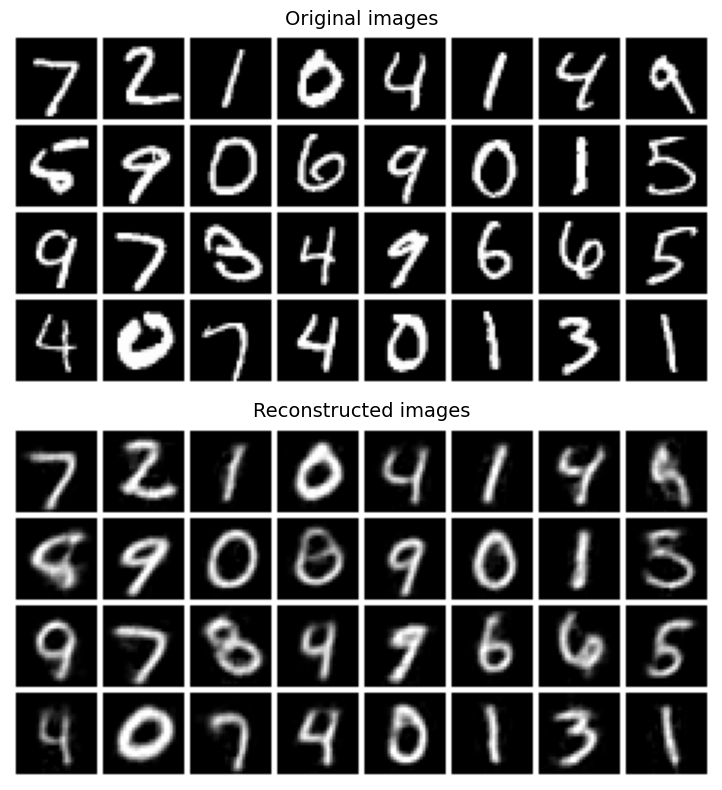

In [15]:
# Combine original and reconstructed images
x_combined = torch.cat([x.cpu(), x_sampled.cpu()], dim=0)  # shape: (64, 1, 28, 28)

grid_top = vutils.make_grid(x.cpu(), nrow=8, pad_value=1)
grid_bottom = vutils.make_grid(x_sampled.cpu(), nrow=8, pad_value=1)

fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Original images
axs[0].imshow(grid_top.permute(1, 2, 0), cmap='gray')
axs[0].axis('off')
axs[0].set_title("Original images", fontsize=14)

# Reconstructed images
axs[1].imshow(grid_bottom.permute(1, 2, 0), cmap='gray')
axs[1].axis('off')
axs[1].set_title("Reconstructed images", fontsize=14)

plt.tight_layout()
plt.savefig("Reconstruction_grid.png", dpi=300)
plt.show()